Aware: a Perceptual Audio Coder
=================

In [12]:
# Python 2.7 Standard Library
from __future__ import division
import argparse
import doctest
import inspect
import pickle
import sys
import time

# Third-Party Libraries
import sh
import numpy as np
import pylab as pl
from pylab import *; seterr(all="ignore")
%matplotlib notebook

# Digital Audio Coding
import audio.io
import bitstream
import breakpoint
import logfile
from audio.filters import MPEG, Analyzer, Synthesizer
from audio.frames import split
import audio.psychoacoustics as psychoacoustics
from audio.psychoacoustics import ATH, bark, hertz, Mask
from audio.quantizers import Quantizer, ScaleFactor, Uniform
import audio.wave as wave

Metadata and Constants
----------------------

In [13]:
__author__ = u"Sébastien Boisgérault <Sebastien.Boisgerault@mines-paristech.fr>"
__license__ = "MIT License"
__version__ = None

# sampling frequency / time
df = 44100.0
dt = 1.0 / df

# fft window size
N_FFT = 512

# filter length (FIR)
N = MPEG.N

# number of subbands
M = MPEG.M

# frame size for the subband quantizer
L = 12 * M

# number of bits available for every sequence of M subband samples
BIT_POOL = 112
assert BIT_POOL <= M * 16

# scale factor used by the subband quantizer 
SCALE_FACTORS = logspace(1, -20, 64, base=2.0)[::-1] 

Signal Generators
-----------------

In [14]:
def tone(f=440.0, N=512, phi=0.0):
    t = arange(N) * dt
    return cos(2*pi*f*t + phi)

def white_noise(N=512):
    return uniform(low=-1.0, high=1.0, size=N)

def square(f=440.0, N=512): 
    n = int(round_(0.5 * (df / f)))
    period = reshape(r_[ones(n), -1.0 * ones(n)], (1, 2*n))
    return ravel(repeat(period, N //(2*n) + 1, axis=0))[:N]
   

<IPython.core.display.Javascript object>


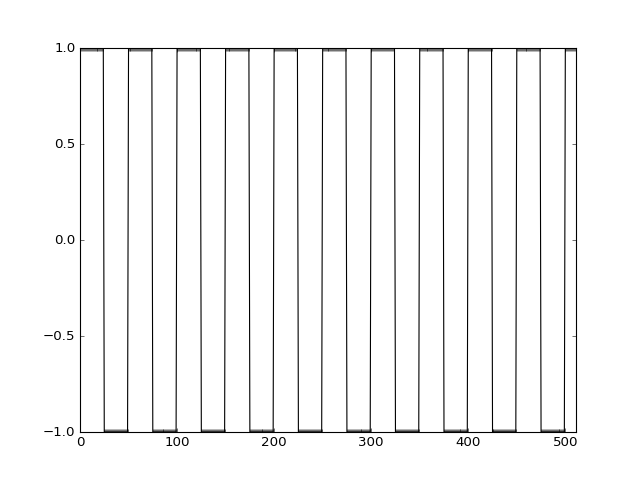

(0.0, 511.0, -1.0, 1.0)

In [15]:
figure()
plot(square(f=880),"k-+"); axis("tight")

In [16]:
audio.io.play(tone(f=440.0, N=512*300))
audio.io.play(0.8*square(f=440.0, N=512*300))

Subband Decomposition
-----------------------

<IPython.core.display.Javascript object>


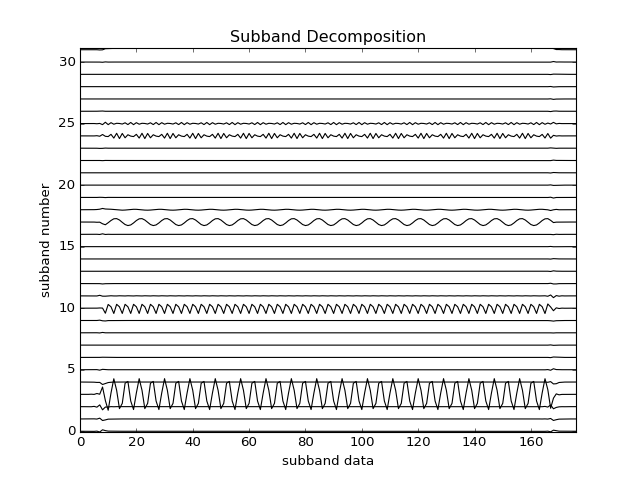

In [17]:
def display_subbands(data):
    analyze = Analyzer(MPEG.A, dt=MPEG.dt)
    # Add zeros at the head to implement strictly the polyphase filter
    # and add zeros at the tail to account for the filter-induced delay.
    data = r_[np.zeros(M-1), data, np.zeros(N)]
    frames = np.array(split(data, MPEG.M, pad=True))
    subband_frames = transpose([analyze(frame) for frame in frames])
    assert shape(subband_frames)[0] == M
    for i, data in enumerate(subband_frames):
        pl.plot(data + i*1.0, "k-")
    pl.title("Subband Decomposition")
    pl.ylabel("subband number")
    pl.xlabel("subband data")
    pl.axis("tight")

figure()
display_subbands(square(f=22050/32.0*3.5, N=512*10))    

Perceptual Model
------------------

<IPython.core.display.Javascript object>


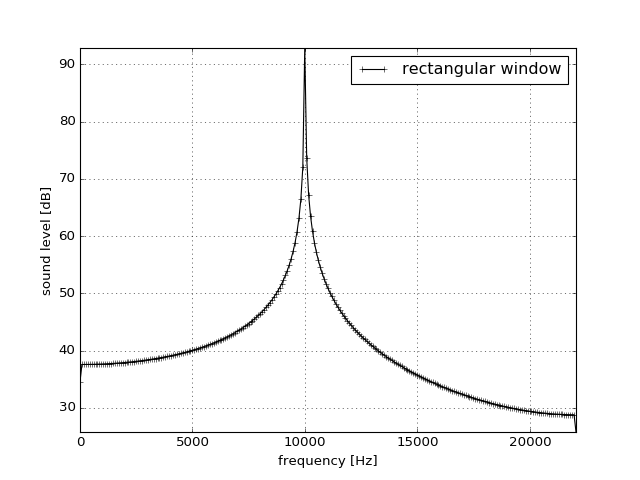

In [18]:
def raw_maskers(frame, window=hanning):
    frame = array(frame, copy=False)
    if shape(frame) != (N,):
        error = "the frame should be 1-dim. with {0} samples."
        raise TypeError(error.format(N))

    # Compute a gain alpha that compensates the energy loss caused by the 
    # windowing -- a frame with constant values is used as a reference.
    alpha = 1.0 / sqrt(sum(window(N)**2) / N)
    x = alpha * window(N) * frame
    
    k = arange(N // 2 + 1)
    frame_fft_2 = abs(fft(x)) ** 2

    # sum(P) is the normalized sound power: <x**2>
    # print mean(x*x), sum(P)
    P = 2.0 * frame_fft_2[:(N // 2 + 1)] / N / N
    P[0] = 0.5 * P[0]
    if (N % 2 == 0):
        P[-1] = 0.5 * P[-1]

    # +96 dB normalization
    P = 10.0 ** (96.0 / 10.0) * P
    
    return k, P

data = tone(f=10000.0)
k, P = raw_maskers(data, window=ones)
k, Ph = raw_maskers(data, window=hanning)
figure()
f_k = k * df / N
PdB = 10.0*log10(P)
PhdB = 10.0*log10(Ph)
plot(f_k, PdB, "k-+", label="rectangular window")
#plot(f_k, PhdB, "b-",label="hanning window")
axis("tight")
grid(True)
xlabel("frequency [Hz]")
ylabel("sound level [dB]")
legend(loc=0)

<IPython.core.display.Javascript object>


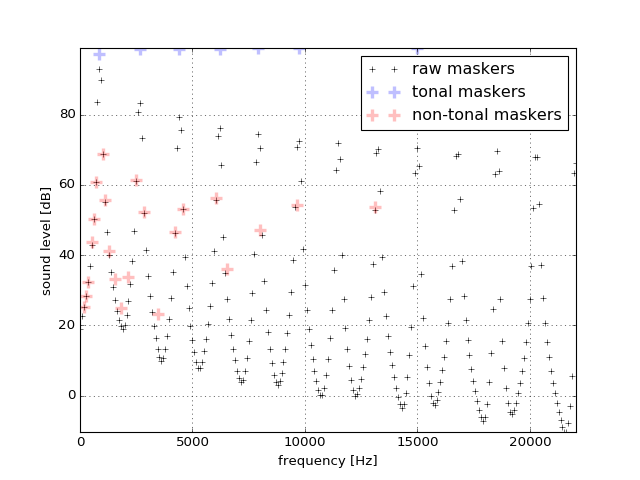

In [19]:
class Classifier(object):
    "Tone/Noise Classifier"
    def __init__(self):
        small  = np.array([-2, +2])
        medium = np.array([-3, -2, +2, +3]) 
        large  = np.array([-6, -5, -4, -3, -2, +2, +3, +4, +5, +6])
        self.neighbourhood = 256 * [None]
        for _k in range(2, 63):
            self.neighbourhood[_k] = small
        for _k in range(63, 127):
            self.neighbourhood[_k] = medium
        for _k in range(127, 251):
            self.neighbourhood[_k] = large        
    def __call__(self, k, P):
        assert all(k == np.arange(0, N // 2 + 1))
        k = array(k)
        P = array(P)
        tonals = np.zeros_like(k, dtype=bool)
        skip = tonals.copy()
        for _k in arange(0, N // 2 + 1):
            if _k >= 3 and _k < 251:
              if (P[_k-1] <= P[_k] and P[_k+1] <= P[_k]): # local maximum
                js = self.neighbourhood[_k]
                if all(P[_k] >= 5.0 * P[_k+js]): # +7.0 dB
                    tonals[_k] = True
                    skip[_k-1] = skip[_k+1] = True
                    
        non_tonals = np.logical_not(np.logical_or(tonals, skip))

        k_nt = k[non_tonals]
        P_nt = P[non_tonals]
        k_t = k[tonals]
        Pc = P.copy()
        for i in arange(1,len(Pc)-1):
            Pc[i] = Pc[i-1] + Pc[i] + Pc[i+1] 
        P_t = Pc[tonals]


        return (k_t, P_t), (k_nt, P_nt)        

classify = Classifier()

def group_by_critical_band(k, P):
    # cb_k: critical band number indexed by frequency line index k.
    f_k = arange(N // 2 + 1) * df / N
    b_k = bark(f_k)
    cb_k = array([int(b) for b in floor(b_k)])
    bands = [[[], []] for _ in arange(np.amax(cb_k) + 1)]
    for _k, _P in zip(k, P):
        band = bands[cb_k[_k]]
        band[0].append(_k)
        band[1].append(_P)
    for b, band in enumerate(bands):
        bands[b] = (np.array(band[0]), np.array(band[1]))
    return bands

def merge_tonals(k_t, P_t):
    bands = group_by_critical_band(k_t, P_t)
    k_t_out, P_t_out = [], []
    for band, k_P_s in enumerate(bands):
        if len(k_P_s[0]):
            k_max = None
            P_max = - inf 
            for _k, _P in zip(*k_P_s):
               if _P > P_max:
                   k_max = _k
                   P_max = _P
            k_t_out.append(k_max)
            P_t_out.append(P_max)
    return array(k_t_out), array(P_t_out)

def merge_non_tonals(k_nt, P_nt):
    bands = group_by_critical_band(k_nt, P_nt)
    k_nt_out = np.zeros(len(bands), dtype=uint8)
    P_nt_out = np.zeros(len(bands))
    for band, k_P_s in enumerate(bands):
        if len(k_P_s[0]):
            k, P = k_P_s
            P_sum = np.sum(P)
            # k_mean: not sure that's the best thing to do.
            # geometric mean suggested by Rosi. I believe that an 
            # arithmetic mean in the bark scale is better yet.

            if P_sum == 0.0:
                P = np.ones_like(P)
            k_mean = int(np.round(np.average(k, weights=P))) 
            k_nt_out[band] = k_mean
            P_nt_out[band] = P_sum
    return k_nt_out, P_nt_out

def threshold(k, P):
    f_k = arange(N // 2 + 1) * df / N
    ATH_k = 10 ** (ATH(f_k) / 10.0)
    k_out, P_out = [], []
    for (_k, _P) in zip(k, P):
        if _P > ATH_k[_k]:
            k_out.append(_k)
            P_out.append(_P)
    return array(k_out), array(P_out)

def maskers(frame):
    k, P = raw_maskers(frame)
    (k_t, P_t), (k_nt, P_nt) = classify(k, P)
    k_t, P_t = merge_tonals(k_t, P_t)
    k_nt, P_nt = merge_non_tonals(k_nt, P_nt)
    k_t, P_t = threshold(k_t, P_t)
    k_nt, P_nt = threshold(k_nt, P_nt)
    return (k_t, P_t), (k_nt, P_nt)

data = square(2*440.0)
k, P = raw_maskers(data)
(k_t, P_t), (k_nt, P_nt) = maskers(data)
figure()
f_k = k * df / N
f_k_t = k_t * df / N
f_k_nt = k_nt * df / N
PdB = 10.0*log10(P)
P_t_dB = 10.0 * log10(P_t)
P_nt_dB = 10.0*log10(P_nt)
plot(f_k, PdB, "k+", label="raw maskers")
plot(f_k_t, P_t_dB, "b+", ms=10, mew=3, alpha=0.25, label="tonal maskers")
plot(f_k_nt, P_nt_dB, "r+",ms=10, mew=3, alpha=0.25,label="non-tonal maskers")
axis("tight")
grid(True)
xlabel("frequency [Hz]")
ylabel("sound level [dB]")
legend(loc=0)

In [20]:
def excitation_pattern(b, b_m, I, tonal):
    """
    Compute the excitation pattern of a single masker.

    The spread function and attenuation factors are from MPEG-1 Audio Model 1.

    Arguments
    ---------

      - `b`: scalar or array of frequencies in barks,
      - `b_m`: masker frequency (in barks),
      - `I`: masker power (in dB),
      - `tonal`: `True` if the masker is tonal, `False` otherwise.

    Returns
    -------

      - `mask`: array of excitation values in dB.

    """
    db = b - b_m

    db_1 = np.minimum(db + 1.0, 0.0)
    db_2 = np.minimum(db      , 0.0)
    db_3 = np.maximum(db      , 0.0)
    db_4 = np.maximum(db - 1.0, 0.0)    

    mask  = I \
          + (11.0 - 0.40 * I) * db_1 \
          + ( 6.0 + 0.40 * I) * db_2 \
          - (17.0           ) * db_3 \
          + (       0.15 * I) * db_4

    if tonal:
        mask += -1.525 - 0.275 * b - 4.5
    else:
        mask += -1.525 - 0.175 * b - 0.5
    return mask

# k is the frequency line index (257 values), i a subsampling (112 values).
k = arange(N // 2 + 1)
f_k = k * df / N
b_k = bark(f_k)

k_i = r_[0:49, 49:97:2, 97:251:4]
f_i = k_i * df / N
b_i = bark(f_i)
ATH_i = ATH(f_i)
subband_i = array([int(s) for s in floor(f_i / (0.5 * df / 32))])

def mask_from_frame(frame):
    """
    Compute the mask function for a frame.

    Arguments
    ---------

    - `frame`: sequence of 512 samples,

    Returns
    -------

    - `mask`: an array of 32 subband mask level values in dB.

    """

    # compute the mask floor (linear scale)    
    mask_i = 10.0 ** (ATH_i / 10.0)

    # add the tonals and non-tonals mask values.
    (k_t, P_t), (k_nt, P_nt) = maskers(frame)
    for masker_index in arange(len(k_t)):
        _b, _P = b_k[k_t[masker_index]], P_t[masker_index]
        mask_i += 10.0 ** (excitation_pattern(b_i, b_m=_b, I=10.0*log10(_P), tonal=True) / 10.0)
    for masker_index in arange(len(k_nt)):
        _b, _P = b_k[k_nt[masker_index]], P_nt[masker_index]
        mask_i += 10.0 ** (excitation_pattern(b_i, b_m=_b, I=10.0*log10(_P), tonal=False) / 10.0)

    # convert the resulting mask value to dB
    mask_i = 10.0 * log10(mask_i)

    # select the lowest mask value in each of the 32 subbands.
    subband_mask = [[] for _ in range(32)]
    for i, _mask_i in enumerate(mask_i):
        subband_mask[subband_i[i]].append(_mask_i)
    for i, _masks in enumerate(subband_mask):
        subband_mask[i] = amin(_masks)
    return array(subband_mask)

<IPython.core.display.Javascript object>


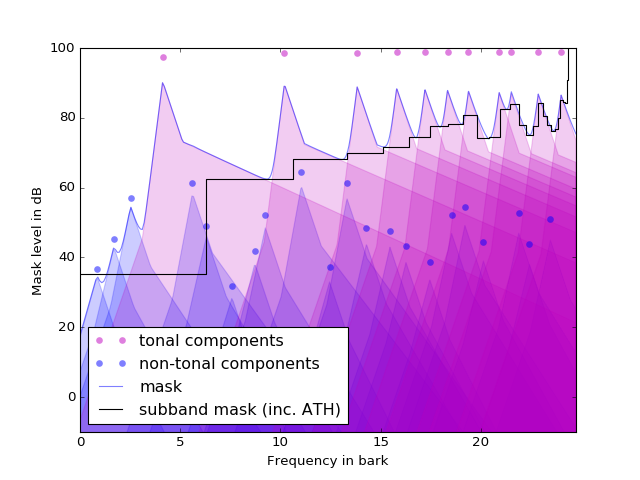

In [21]:
def display_maskers(frame):
    # f array for high-resolution (10 Hz)
    n = int(22050.0 / 10.0)
    f = arange(n + 1) / float(n + 1) * 0.5 * df 
    b = psychoacoustics.bark(f)
    
    k, P = raw_maskers(frame)
    P = clip(P, 1e-100, 1e100) # convenience patch for plots

    (k_t, P_t), (k_nt, P_nt) = classify(k, P)
    k_t_m, P_t_m = merge_tonals(k_t, P_t)
    k_nt_m, P_nt_m = merge_non_tonals(k_nt, P_nt)
    k_t_m_t, P_t_m_t = threshold(k_t_m, P_t_m)
    k_nt_m_t, P_nt_m_t = threshold(k_nt_m, P_nt_m)

    # compute the mask floor (linear scale)    
    mask_i = 10.0 ** (ATH_i / 10.0)

    # add the tonals and non-tonals mask values.
    (k_t, P_t), (k_nt, P_nt) = maskers(frame)
    for masker_index in arange(len(k_t)):
        _b, _P = b_k[k_t[masker_index]], P_t[masker_index]
        mask_i += 10.0 ** (excitation_pattern(b_i, b_m=_b, I=10.0*log10(_P), tonal=True) / 10.0)
    for masker_index in arange(len(k_nt)):
        _b, _P = b_k[k_nt[masker_index]], P_nt[masker_index]
        mask_i += 10.0 ** (excitation_pattern(b_i, b_m=_b, I=10.0*log10(_P), tonal=False) / 10.0)

    mask_i = 10.0 * log10(mask_i)
    
    plot(bark(k_t_m_t*df/N), 10.0*log10(P_t_m_t), "mo", alpha=0.5, mew=0.0, label="tonal components")  
    plot(bark(k_nt_m_t*df/N), 10.0*log10(P_nt_m_t), "bo", alpha=0.5, mew=0.0, label="non-tonal components") 

    P_tot = 0.0
    for _k, _P in zip(k_nt_m_t, P_nt_m_t):
        _b = psychoacoustics.bark(_k * df / N)
        ep = excitation_pattern(b, b_m=_b, I=10.0*log10(_P), tonal=False)
        P_tot += 10.0 ** (ep / 10.0)
        fill_between(bark(f), 10.0*log10(1e-10*ones_like(f)), ep, color="b", alpha=0.2)

    for _k, _P in zip(k_t_m_t, P_t_m_t):
        _b = psychoacoustics.bark(_k * df / N)
        ep = excitation_pattern(b, b_m=_b, I=10.0*log10(_P), tonal=True)
        P_tot += 10.0 ** (ep / 10.0)
        fill_between(bark(f), 10.0*log10(1e-10*ones_like(f)), ep, color="m", alpha=0.2)


    P_tot = 10 * log10(P_tot)
    xlabel("Frequency in bark")
    ylabel("Mask level in dB")
    plot(bark(f), P_tot, "-", color="blue", label="mask", alpha=0.5)

# --------------------------------------------------------

    m = mask_from_frame(frame)
    b_subbands = psychoacoustics.bark((arange(32) + 0.5) * (0.5 * df / 32))
    #plot(b_subbands, m, "ro", label="subband mask")
    b_boundaries = ravel(split(psychoacoustics.bark(arange(33) * (0.5 * df / 32)), 2, overlap=1))
    values = ravel([[_m, _m] for _m in m])
    plot(b_boundaries, values, "k", label=r"subband mask (inc. ATH)")
    #fill_between(b_boundaries, -100*ones_like(values), values, color="r", alpha=0.3)

    x_min, x_max = 0, psychoacoustics.bark(0.5 * df)
    xticks(r_[0:26:5])
    y_min = -10.0
    y_max = 100.0

    axis([x_min, x_max, y_min, y_max])

    #grid(True)
    legend(loc=0)

figure()
display_maskers(square(f=440.0) )   

Subband Data Vector (Scale Factors) Quantizers
------------------------------------------------------------------------------

In [22]:
def allocate_bits(frames, mask, bit_pool=BIT_POOL):
    """
    Arguments
    ---------

      - `frames:` an array of shape 12 x 32. The array `frames[:,i]` shall
        contain 12 consecutive samples generated for the subband `i` by 
        the MPEG analysis filter bank.
      
      - `mask:` a sequence of 32 mask intensity level in dB, one for each
        subband.
    
    Returns
    -------

      - `bits`: the number of bits allocated in each subband.    
    
    """
    assert shape(frames) == (12, 32)
    assert shape(mask) == (32,)

    assert bit_pool <= M * 16

    sf_quantizer = ScaleFactor(SCALE_FACTORS)
    sf_subband = zeros(32)
    for subband, frame in enumerate(transpose(frames)):
        sf_index = sf_quantizer.index(frame)
        sf_subband[subband] = SCALE_FACTORS[sf_index]

    bits = zeros(32, dtype=uint8)
    delta = 2.0 * sf_subband
    noise_level = 96.0 + 10 * log10((delta ** 2) / 12.0)
    noise_to_mask = noise_level - mask
    delta_dB = 10.0 * log10(2.0)
    while bit_pool >= 2:
        subband = np.argmax(noise_to_mask)
        # avoid subbands with a single bit allocated.
        num_bits = 1 + (bits[subband] == 0)
        bits[subband] += num_bits                   
        if bits[subband] < 16:
            noise_to_mask[subband] -= num_bits * delta_dB
        else: # maximal number of bits reached for this subband
            noise_to_mask[subband] = - np.inf
        bit_pool = bit_pool - num_bits
    if bit_pool != 0: 
        noise_to_mask[bits == 0] = -inf
        subband = np.argmax(noise_to_mask)
        if 0 < bits[subband] < 16: # call me paranoid.
            bits[subband] += 1

    return bits


class SubbandQuantizer(Quantizer):
    def __init__(self, mask=None, bit_pool=BIT_POOL):
        self.mask = mask
        self.bit_pool = bit_pool
        self.bits = []

    def encode(self, frames):
        frames = np.array(frames)
        assert np.shape(frames) == (12, 32)
        bits = allocate_bits(frames, self.mask, bit_pool=self.bit_pool)
        self.bits.append(bits)
        quantizers = []
        for i, bit in enumerate(bits):
            N = 2**bit - 1
            quantizer = ScaleFactor(SCALE_FACTORS, Uniform(-1.0, 1.0, N))
            quantizers.append(quantizer)
        output = []
        for subband, frame in enumerate(transpose(frames)):
            index, codes = quantizers[subband].encode(frame)
            output.append([bits[subband], index, codes])
        return output

    def decode(self, data):
        frames = []
        for subband in range(32):
            bit, index, codes = data[subband]
            N = 2**bit - 1
            uniform_quantizer = Uniform(-1.0, 1.0, N)
            quantizer = ScaleFactor(SCALE_FACTORS, uniform_quantizer)
            frames.append(quantizer.decode((index, codes)))
        return array(transpose(frames))


In [23]:
# 
# Unit Test Runner
# ------------------------------------------------------------------------------
#

def test_allocate_bits():
    """
    >>> frame = np.ones((12, 32))
    >>> mask = 50.0 * ones(32)
    >>> bits = allocate_bits(frame, mask, 0)
    >>> all(bits == 0)
    True
    >>> bits = allocate_bits(frame, mask, 32*16)
    >>> all(bits == 16)
    True
    >>> bits = allocate_bits(frame, mask, 112)
    >>> all(3 <= bits) and all(bits <= 4)
    True

    >>> frame = np.zeros((12, 32))
    >>> for i in range(7):
    ...    frame[:,i] = 1.0
    >>> bits = allocate_bits(frame, mask, 112)
    >>> all(bits[:7] == 16) and all(bits[7:] == 0)
    True
    """

def test(verbose=False):
    """
    Run the doctests of this module.
    """
    return doctest.testmod(verbose=verbose)

test()

TestResults(failed=0, attempted=12)

Aware Compression Demo
=============

<IPython.core.display.Javascript object>


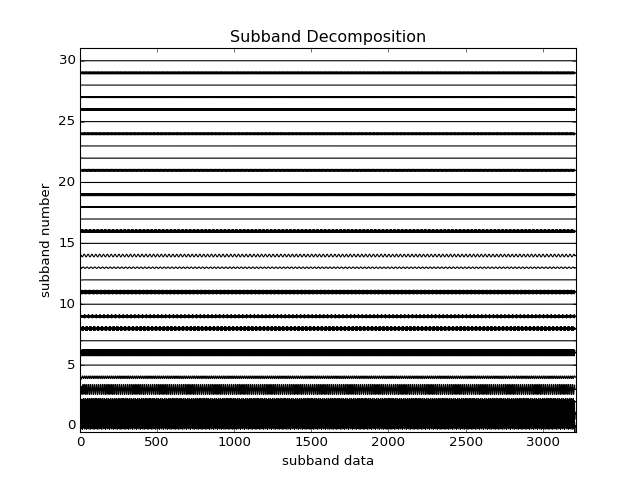

In [24]:
data = square(f=880.0, N=512*200) # 0.5 * (tone(440.0, 512*100) + tone(10000, 512*100))
assert len(data) >= 1024    

figure()
display_subbands(data)

<IPython.core.display.Javascript object>


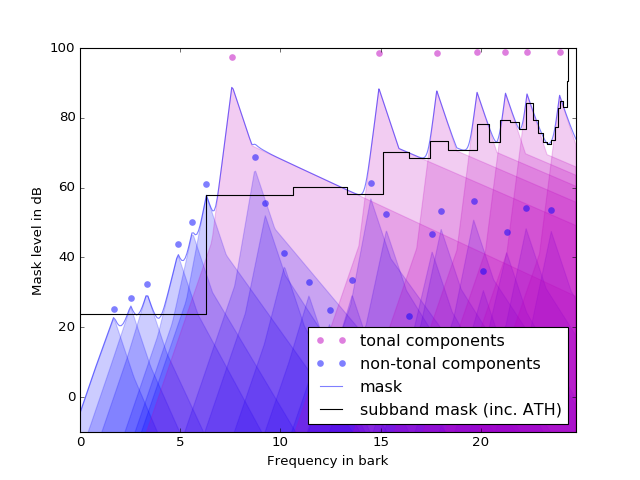

In [25]:
# Compute the single mask used for every bit allocation.
reference_frame = data[:512]
length = len(data)
mask = mask_from_frame(reference_frame)

figure()
display_maskers(reference_frame)

<IPython.core.display.Javascript object>


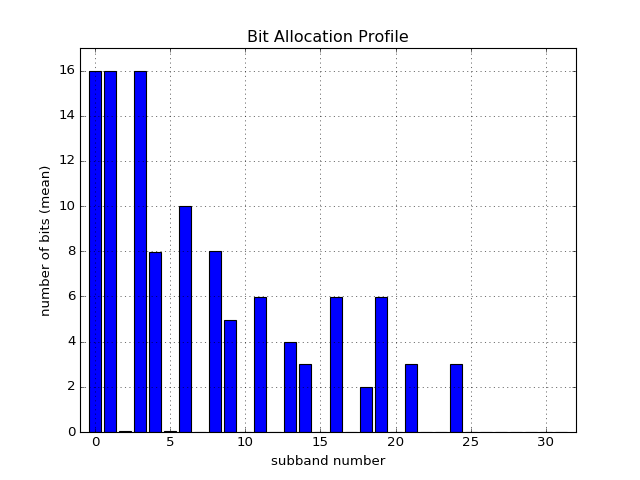

[-1, 32, 0, 17.0]

In [26]:
bit_pool=BIT_POOL
# Apply the analysis filter bank.
analyze = Analyzer(MPEG.A, dt=MPEG.dt)
data = r_[data, zeros(512)] # take into account the delay:
# without this extra frame, we may not have enough output values.
frames = array(split(data, MPEG.M, pad=True))
subband_frames = array([analyze(frame) for frame in frames])

# Make sure we have an entire numbers of 12-sample frames.
remainder = shape(subband_frames)[0] % 12
if remainder:
    subband_frames = r_[subband_frames, zeros((12-remainder, 32))]

# Quantize the data in each subband.
quant_subband_frames = []
subband_quantizer = SubbandQuantizer(mask, bit_pool=bit_pool)
for i in range(shape(subband_frames)[0] // 12):
    subband_frame = subband_frames[i*12:(i+1)*12]
    quant_subband_frames.append(subband_quantizer(subband_frame))

mean_bits = mean(subband_quantizer.bits, axis=0)
figure()
bar(arange(32.0)-0.4, mean_bits)
xlabel("subband number")
ylabel("number of bits (mean)")
title("Bit Allocation Profile")
grid(True)
axis([-1, 32, 0, max(mean_bits) + 1])

<IPython.core.display.Javascript object>


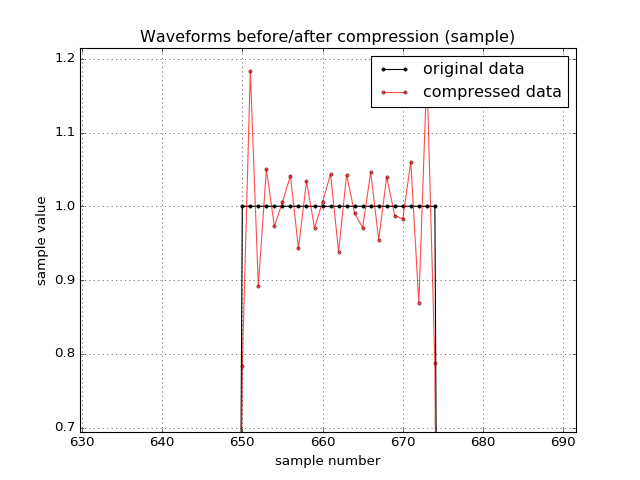

In [27]:
# Reconstruct the approximation of the original audio data 
synthesize = Synthesizer(MPEG.S, dt=MPEG.dt, gain=MPEG.M)
output = []
for frame_12 in quant_subband_frames:
    for frame in frame_12:
        output.extend(synthesize(frame))

# Synchronize input and output data.
_delay = 481 # magic number ...
output = output[_delay:length+_delay]

figure()
plot(arange(512, 1024), data[512:1024], "k-o", ms=3.0, label="original data")
plot(arange(512, 1024), output[512:1024], "r-o", ms=3.0, alpha=0.7, label="compressed data")
xlabel("sample number")
ylabel("sample value")
grid(True)
axis("tight")
legend()
title("Waveforms before/after compression (sample)")


In [31]:
audio.io.play(data, df=df)

In [32]:
audio.io.play(output, df=df)

In [30]:
print "bits/band:", BIT_POOL/M
print "compression rate:", 16 / (BIT_POOL / M) 
print 1.4 / 4.57

bits/band: 3.5
compression rate: 4.57142857143
0.306345733042
